<a href="https://colab.research.google.com/github/thuvarahan97/Pump-it-Up---Driven-Data/blob/main/PumpItUp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries and Dataset**

In [1435]:
# pip install catboost

In [1436]:
# load numpy
import numpy as np

# load pandas
import pandas as pd

# load matplot lib for various plotting
import matplotlib.pyplot as plt   
%matplotlib inline

# for visually appealing plots
import seaborn as sns

# to use the Logit()
import statsmodels.api as sm

# for cross validation
from sklearn.model_selection import train_test_split

# for preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# for various metrics and reporting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# load classifiers
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold,train_test_split, KFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import Pool, CatBoostClassifier

# SMOTE
from imblearn.over_sampling import SMOTE

# SMOTE-ENN
from imblearn.over_sampling import ADASYN

# SMOTE-ENN
from imblearn.combine import SMOTETomek

# SMOTE-ENN
from imblearn.combine import SMOTEENN


# others
import scipy
import warnings
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from collections import Counter
from numpy import where

In [1437]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1438]:
dir = '/content/drive/My Drive/In17-S7-CS4622 - Machine Learning - 170643M/Pump It Up - Driven Data Challenge/'

In [1439]:
# loading data files
train_set = pd.read_csv(dir + 'training_set_values.csv', parse_dates=True)
train_label = pd.read_csv(dir + 'training_set_labels.csv')
test_set = pd.read_csv(dir + 'test_set_values.csv', parse_dates=True)
submission = pd.read_csv(dir + 'submission_format.csv')

In [1440]:
# displaying training dataset
train_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [1441]:
train_set.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [1442]:
# displaying test dataset
test_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [1443]:
test_set.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,14850.000000,14850.000000,14850.000000,14850.000000,1.485000e+04,14850.000000,14850.000000,14850.000000,14850.000000,14850.000000
mean,37161.972929,322.826983,655.147609,34.061605,-5.684724e+00,0.415084,15.139057,5.626397,184.114209,1289.708350
std,21359.364833,2510.968644,691.261185,6.593034,2.940803e+00,8.167910,17.191329,9.673842,469.499332,955.241087
min,10.000000,0.000000,-57.000000,0.000000,-1.156459e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18727.000000,0.000000,0.000000,33.069455,-8.443970e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37361.500000,0.000000,344.000000,34.901215,-5.049750e+00,0.000000,12.000000,3.000000,20.000000,1986.000000
75%,55799.750000,25.000000,1308.000000,37.196594,-3.320594e+00,0.000000,17.000000,5.000000,220.000000,2004.000000
max,74249.000000,200000.000000,2777.000000,40.325016,-2.000000e-08,669.000000,99.000000,80.000000,11469.000000,2013.000000


In [1444]:
# displaying training labels
y = train_label['status_group'].values
train_label.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [1445]:
# size of training dataset
train_set.shape

(59400, 40)

In [1446]:
# size of test dataset
test_set.shape

(14850, 40)

# **Preprocessing Dataset**

In [1447]:
# Assign index to each dataset
train_set = train_set.set_index('id')
test_set = test_set.set_index('id')

In [1448]:
# display all train data columns
train_set.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [1449]:
# numeric_col = np.where(train_set.dtypes != object)[0]
# numeric_feat = [train_set.columns[x] for x in numeric_col]

Text(0.5, 1.0, 'Status Group vs. Count')

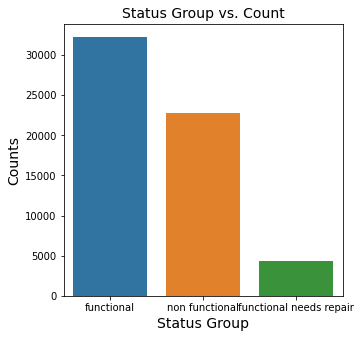

In [1450]:
# Bar plot for counts in each class in train data
plt.subplots(figsize=(5,5))
sns.countplot(x='status_group', data=train_label)
plt.xlabel('Status Group', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('Status Group vs. Count', fontsize=14)

### **Check distribution of features with train labels**

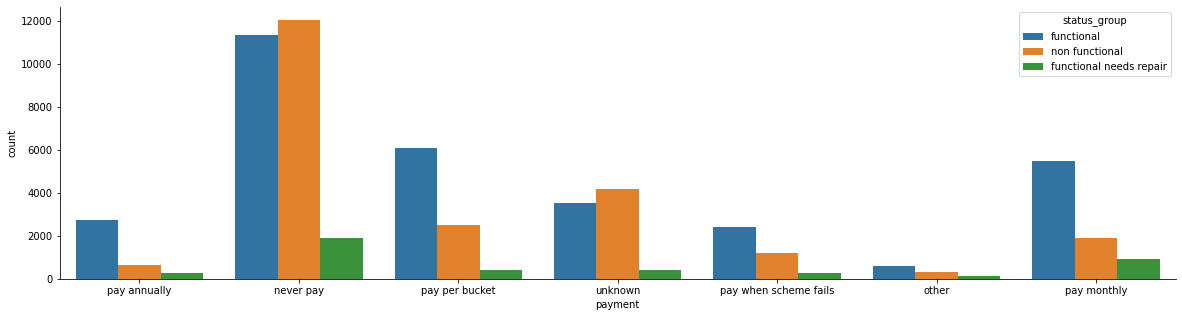

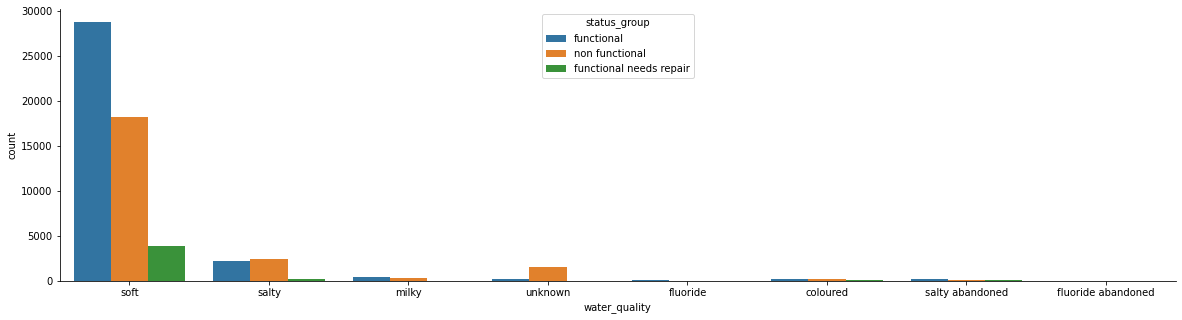

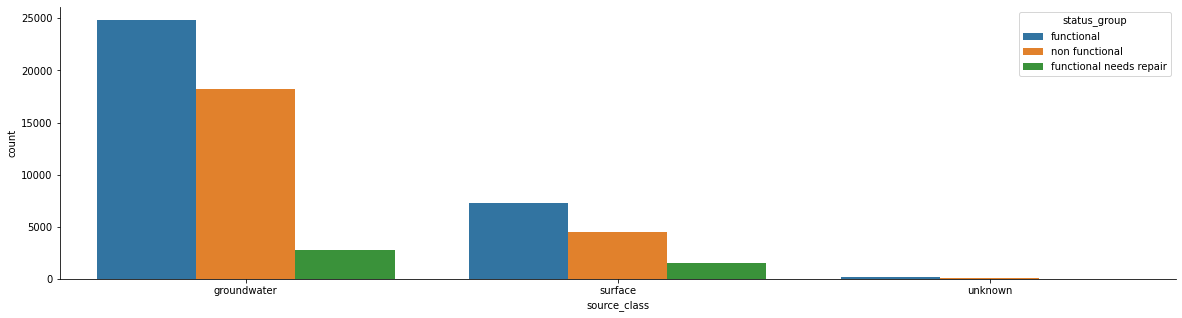

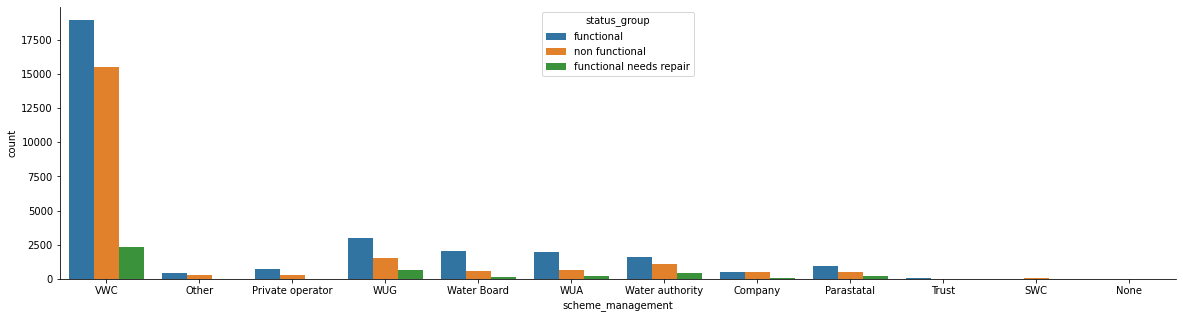

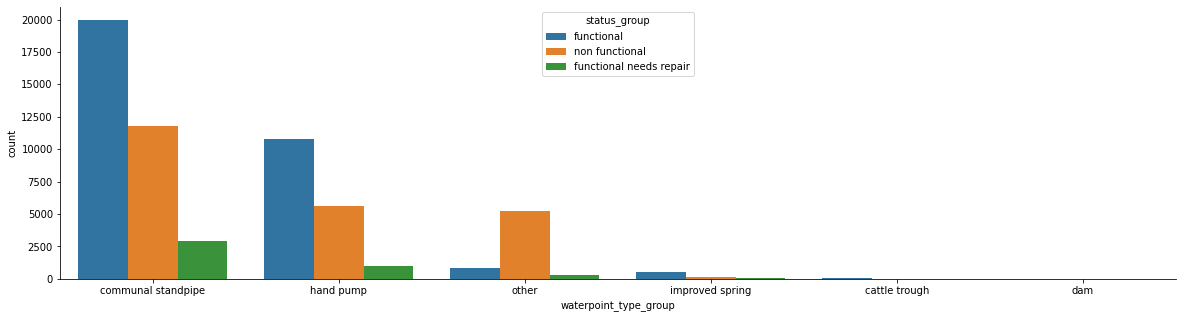

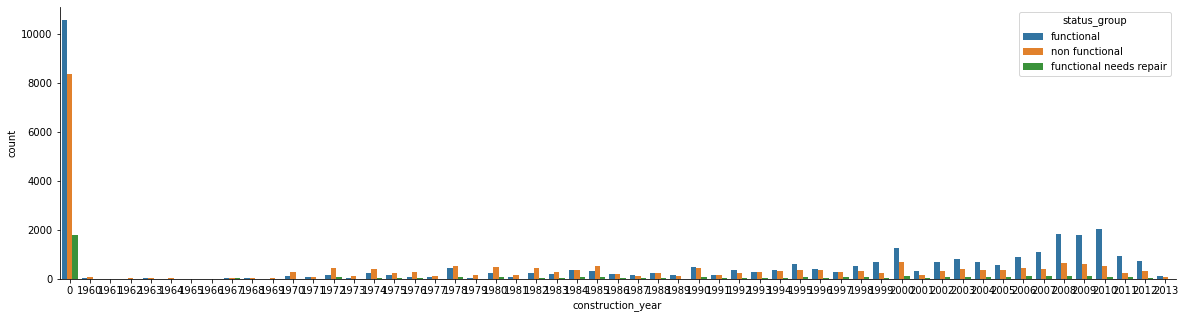

In [1451]:
def plotDataGraph(x):
  # df2.plot.barh(stacked=True);
  temp = train_set.copy()
  temp['status_group'] = y
  # temp = temp.groupby(['status_group', x]).size().reset_index().pivot(columns='status_group', index=x)
  fig, axs = plt.subplots(figsize=(20, 5))
  plot = sns.countplot(x=x, hue='status_group', data=temp)
  sns.despine()


plot_cols=['payment','water_quality','source_class','scheme_management','waterpoint_type_group', 'construction_year']
for i in range(0, len(plot_cols)):
  plotDataGraph(plot_cols[i])

### **Remove duplicate values from "installer" and "funder" columns**

In [1452]:
train_set['installer'].value_counts()

DWE                     17402
Government               1825
RWE                      1206
Commu                    1060
DANIDA                   1050
                        ...  
Private individuals         1
Care  international         1
Centra govt                 1
SERENS                      1
George mtoto company        1
Name: installer, Length: 2145, dtype: int64

In [1453]:
# removing duplication of values in "installer" column
train_set['installer'] = train_set['installer'].str.lower().str.strip().str.split(" ", expand=True)[0].replace("/", "").replace("\\", "")
test_set['installer'] = test_set['installer'].str.lower().str.strip().str.split(" ", expand=True)[0].replace("/", "").replace("\\", "")

In [1454]:
# display count of values in "installer" column before modification
train_set['installer'].value_counts()

dwe           17407
government     1898
hesawa         1395
rwe            1223
district       1192
              ...  
salum             1
twess             1
hashi             1
mwl               1
latifu            1
Name: installer, Length: 1528, dtype: int64

In [1455]:
# assign "installer" values with count less than 100 to "other"
mask = train_set['installer'].map(train_set['installer'].value_counts()) < 100
train_set['installer'] =  train_set['installer'].mask(mask, 'other')
mask = test_set['installer'].map(test_set['installer'].value_counts()) < 100
test_set['installer'] =  test_set['installer'].mask(mask, 'other')

In [1456]:
# display count of values in "installer" column after modification
train_set['installer'].value_counts()

dwe           17407
other         10697
government     1898
hesawa         1395
rwe            1223
              ...  
muwsa           107
ded             105
wizara          104
oikos           101
hsw             100
Name: installer, Length: 77, dtype: int64

In [1457]:
# display count of values in "funder" column before modification
train_set['funder'].value_counts()

Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Rwssp                      1374
World Bank                 1349
                           ... 
Mzee Smith                    1
Sent Tho                      1
Shinyanga Shallow Wells       1
Nazalet Church                1
Icdp                          1
Name: funder, Length: 1897, dtype: int64

In [1458]:
# assign "funder" values with count less than 100 to "other"
mask = train_set['funder'].map(train_set['funder'].value_counts()) < 100
train_set['funder'] =  train_set['funder'].mask(mask, 'other')
mask = test_set['funder'].map(test_set['funder'].value_counts()) < 100
test_set['funder'] =  test_set['funder'].mask(mask, 'other')

In [1459]:
# display count of values in "funder" column after modification
train_set['funder'].value_counts()

other                            12379
Government Of Tanzania            9084
Danida                            3114
Hesawa                            2202
Rwssp                             1374
                                 ...  
Village Council                    105
Ru                                 105
Halmashauri Ya Wilaya Sikonge      102
Germany                            101
Hsw                                101
Name: funder, Length: 92, dtype: int64

### **Find Missing data**

In [1460]:
# Find the count of null values in train data
train_set.isnull().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [1461]:
# Find the count of null values in test data
test_set.isnull().sum()

amount_tsh                  0
date_recorded               0
funder                    869
gps_height                  0
installer                 877
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                 99
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            821
recorded_by                 0
scheme_management         969
scheme_name              7092
permit                    737
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_g

In [1462]:
# Find the missing data
def findMissingData(data, title):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    missingdata=pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])
    missingdata= missingdata[missingdata["Percentage"] > 0]

    plt.subplots(figsize=(15,5))
    sns.barplot(missingdata.index, missingdata["Percentage"])
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.title('Feature vs. Percentage of missing data in ' + title, fontsize=14)
    
    return missingdata

Missing values in Train Data
Missing values in Test Data


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,Total,Percentage
scheme_name,7092,47.757576
scheme_management,969,6.525253
installer,877,5.905724
funder,869,5.851852
public_meeting,821,5.528620
permit,737,4.962963
subvillage,99,0.666667


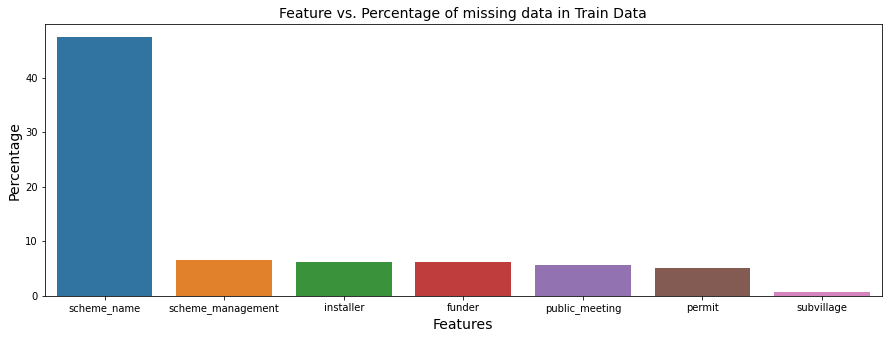

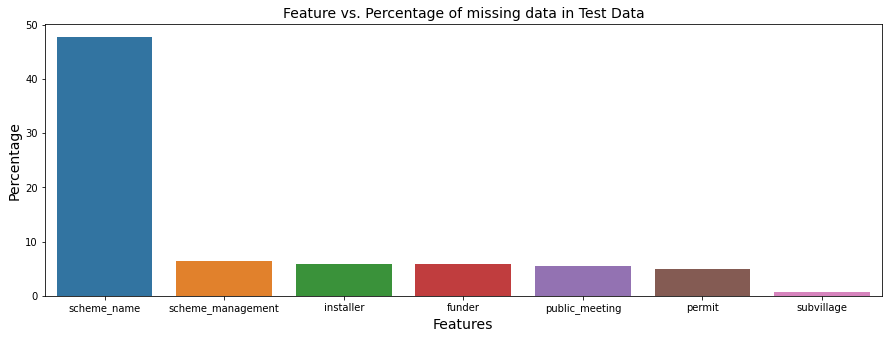

In [1463]:
# Show missing values in train_data
print("Missing values in Train Data")
findMissingData(train_set, "Train Data")

# Show missing values in test_data
print("Missing values in Test Data")
findMissingData(test_set, "Test Data")

### **Convert column values to numeric using Label Encodeing**

In [1464]:
transform_cols = ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 
                  'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 
                  'scheme_management', 'permit', 'extraction_type', 
                  'extraction_type_group', 'extraction_type_class', 'management',
                  'management_group', 'payment', 'payment_type', 'water_quality',
                  'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
                  'source_class', 'waterpoint_type', 'waterpoint_type_group']

for x in range(len(transform_cols)):
  train_set[transform_cols[x]] = LabelEncoder().fit_transform(train_set[transform_cols[x]].astype(str).str.strip())
  test_set[transform_cols[x]] = LabelEncoder().fit_transform(test_set[transform_cols[x]].astype(str).str.strip())
  pd.to_numeric(train_set[transform_cols[x]])
  train_set[transform_cols[x]].astype(int)
  pd.to_numeric(test_set[transform_cols[x]])
  test_set[transform_cols[x]].astype(int)

### **Fill missing data**

In [1465]:
# Drop "scheme_name" column in train_set and test_set
train_set.drop(['scheme_name'], axis=1, inplace = True)
test_set.drop(['scheme_name'], axis=1, inplace=True)

In [1466]:
train_set['scheme_management'].fillna(train_set['scheme_management'].median(), inplace = True)
test_set['scheme_management'].fillna(test_set['scheme_management'].median(), inplace = True)

train_set['installer'].fillna(train_set['installer'].median(), inplace = True)
test_set['installer'].fillna(test_set['installer'].median(), inplace = True)

train_set['funder'].fillna(train_set['funder'].median(), inplace = True)
test_set['funder'].fillna(test_set['funder'].median(), inplace = True)

train_set['public_meeting'].fillna(train_set['public_meeting'].median(), inplace = True)
test_set['public_meeting'].fillna(test_set['public_meeting'].median(), inplace = True)

train_set['permit'].fillna(train_set['permit'].median(), inplace = True)
test_set['permit'].fillna(test_set['permit'].median(), inplace = True)

train_set['subvillage'].fillna(train_set['subvillage'].median(), inplace = True)
test_set['subvillage'].fillna(test_set['subvillage'].median(), inplace = True)

### **Remove outliers**

In [1467]:
# remove outliers in latitude and longitude

train_set['latitude'] = np.where(train_set['longitude'] < 1, np.NaN, train_set['latitude'])
test_set['latitude'] = np.where(test_set['longitude'] < 1, np.NaN, test_set['latitude'])

train_set['longitude'] = np.where(train_set['longitude'] < 1, np.NaN, train_set['longitude'])
test_set['longitude'] = np.where(test_set['longitude'] < 1, np.NaN, test_set['longitude'])

train_set["latitude"] = train_set.groupby("region_code")['latitude'].apply(lambda x: x.fillna(x.mean()))
test_set["latitude"] = test_set.groupby("region_code")['latitude'].apply(lambda x: x.fillna(x.mean()))

train_set["longitude"] = train_set.groupby("region_code")['longitude'].apply(lambda x: x.fillna(x.mean()))
test_set["longitude"] = test_set.groupby("region_code")['longitude'].apply(lambda x: x.fillna(x.mean()))

In [1468]:
# remove outliers in gps_height

train_set['gps_height'] = np.where(train_set['gps_height'] < 1, np.NaN, train_set['gps_height'])
test_set['gps_height'] = np.where(test_set['gps_height'] < 1, np.NaN, test_set['gps_height'])

train_set["gps_height"] = train_set.groupby("region_code")['gps_height'].apply(lambda x: x.fillna(x.mean()))
test_set["gps_height"] = test_set.groupby("region_code")['gps_height'].apply(lambda x: x.fillna(x.mean()))

In [1469]:
train_set.head(25)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,64,1390.000000,57,34.938093,-9.856322,37399,0,1,11807,3,11,5,51,1426,109,1,0,7,0,1999,3,1,0,7,4,2,0,6,2,1,1,8,6,0,1,1
8776,0.0,2013-03-06,92,1399.000000,53,34.698766,-2.147466,37195,0,4,15838,9,20,2,103,1576,280,2,0,2,1,2010,3,1,0,11,4,0,2,6,2,2,2,5,3,1,1,1
34310,25.0,2013-02-25,92,686.000000,75,37.460664,-3.821329,14572,0,5,9074,8,21,4,108,1624,250,1,0,7,1,2009,3,1,0,7,4,4,5,6,2,1,1,0,1,1,2,1
67743,0.0,2013-01-28,79,263.000000,68,38.486161,-11.155298,37285,0,7,8982,12,90,63,87,1571,58,1,0,7,1,1986,14,10,5,7,4,0,2,6,2,0,0,3,0,0,2,1
19728,0.0,2011-07-13,92,23.000000,4,31.130847,-1.825359,35529,0,4,7698,4,18,1,26,1687,0,1,0,12,1,0,3,1,0,1,1,0,2,6,2,3,3,5,3,1,1,1
9944,20.0,2011-03-13,50,725.368865,21,39.172796,-4.765587,36137,0,5,11811,20,4,8,68,1322,1,1,0,7,1,2009,14,10,5,7,4,4,5,4,4,1,1,4,2,2,2,1
19816,0.0,2012-10-01,21,1350.981707,22,33.362410,-3.766365,20672,0,0,3796,17,17,3,104,1852,0,1,0,7,1,0,15,11,1,7,4,0,2,6,2,1,1,3,0,0,4,3
54551,0.0,2012-10-09,69,1350.981707,21,32.620617,-4.226198,36483,0,3,16343,17,17,3,25,150,0,1,0,12,1,0,8,5,1,11,4,6,6,3,3,1,1,7,5,0,4,3
53934,0.0,2012-11-03,85,NaN,72,32.711100,-5.146712,21731,0,3,3436,19,14,6,115,434,0,1,0,7,1,0,4,2,1,7,4,0,2,4,4,3,3,3,0,0,4,3


In [1470]:
# check missing values in the train data
train_set.isnull().sum()

amount_tsh                  0
date_recorded               0
funder                      0
gps_height               8819
installer                   0
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                  0
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting              0
recorded_by                 0
scheme_management           0
permit                      0
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_group              0
source    

In [1471]:
# fill missing values in gps_height
train_set['gps_height'].fillna(train_set['gps_height'].mean(), inplace = True)
test_set['gps_height'].fillna(test_set['gps_height'].mean(), inplace = True)

In [1472]:
# replace 0 values in construction_year with a value less than real minimum year

train_set['construction_year'] = pd.to_numeric(train_set['construction_year'])
train_set['construction_year'] = np.where(train_set['construction_year'] <= 0, 1950, train_set['construction_year'])

test_set['construction_year'] = pd.to_numeric(test_set['construction_year'])
test_set['construction_year'] = np.where(test_set['construction_year'] <= 0, 1950, test_set['construction_year'])

In [1473]:
# create period column

train_set['period'] = train_set['date_recorded'].apply(pd.to_datetime) - train_set['construction_year'].apply(lambda x: pd.to_datetime(x,format='%Y'))
train_set['period'] = train_set['period'].astype('timedelta64[D]')
# train_set['period'] = train_set['period'].apply(lambda x: float(x)/(365.25*24*60*60*1e9))
# train_set['period'] = np.where(train_set['period'] < 0, 63.92060232717317, train_set['period'])
train_set['period'] = np.where(train_set['period'] < 0, np.NaN, train_set['period'])
# train_set['month']=pd.to_datetime(train_set['date_recorded']).dt.month

test_set['period'] = test_set['date_recorded'].apply(pd.to_datetime) - test_set['construction_year'].apply(lambda x: pd.to_datetime(x,format='%Y'))
test_set['period'] = test_set['period'].astype('timedelta64[D]')
# test_set['period'] = test_set['period'].apply(lambda x: float(x)/(365.25*24*60*60*1e9))
# test_set['period'] = np.where(test_set['period'] < 0, 63.92060232717317, test_set['period'])
test_set['period'] = np.where(test_set['period'] < 0, np.NaN, test_set['period'])
# test_set['month']=pd.to_datetime(test_set['date_recorded']).dt.month

In [1474]:
# fill missing values in period column

train_set["period"] = train_set.groupby("construction_year")['period'].apply(lambda x: x.fillna(x.mean()))
test_set["period"] = test_set.groupby("construction_year")['period'].apply(lambda x: x.fillna(x.mean()))

In [1475]:
# categorize period into 10 bins
train_set['period'] = pd.cut(train_set['period'], bins=5)
test_set['period'] = pd.cut(test_set['period'], bins=5)

In [1476]:
# convert to period bins to numerical using label encoder
train_set['period'] = LabelEncoder().fit_transform(train_set['period'])
test_set['period'] = LabelEncoder().fit_transform(test_set['period'])

In [1477]:
to_drop = ['construction_year', 'date_recorded']
train_set.drop(to_drop, axis=1, inplace=True)
test_set.drop(to_drop, axis=1, inplace=True)

### **Analyzing correlation between features**

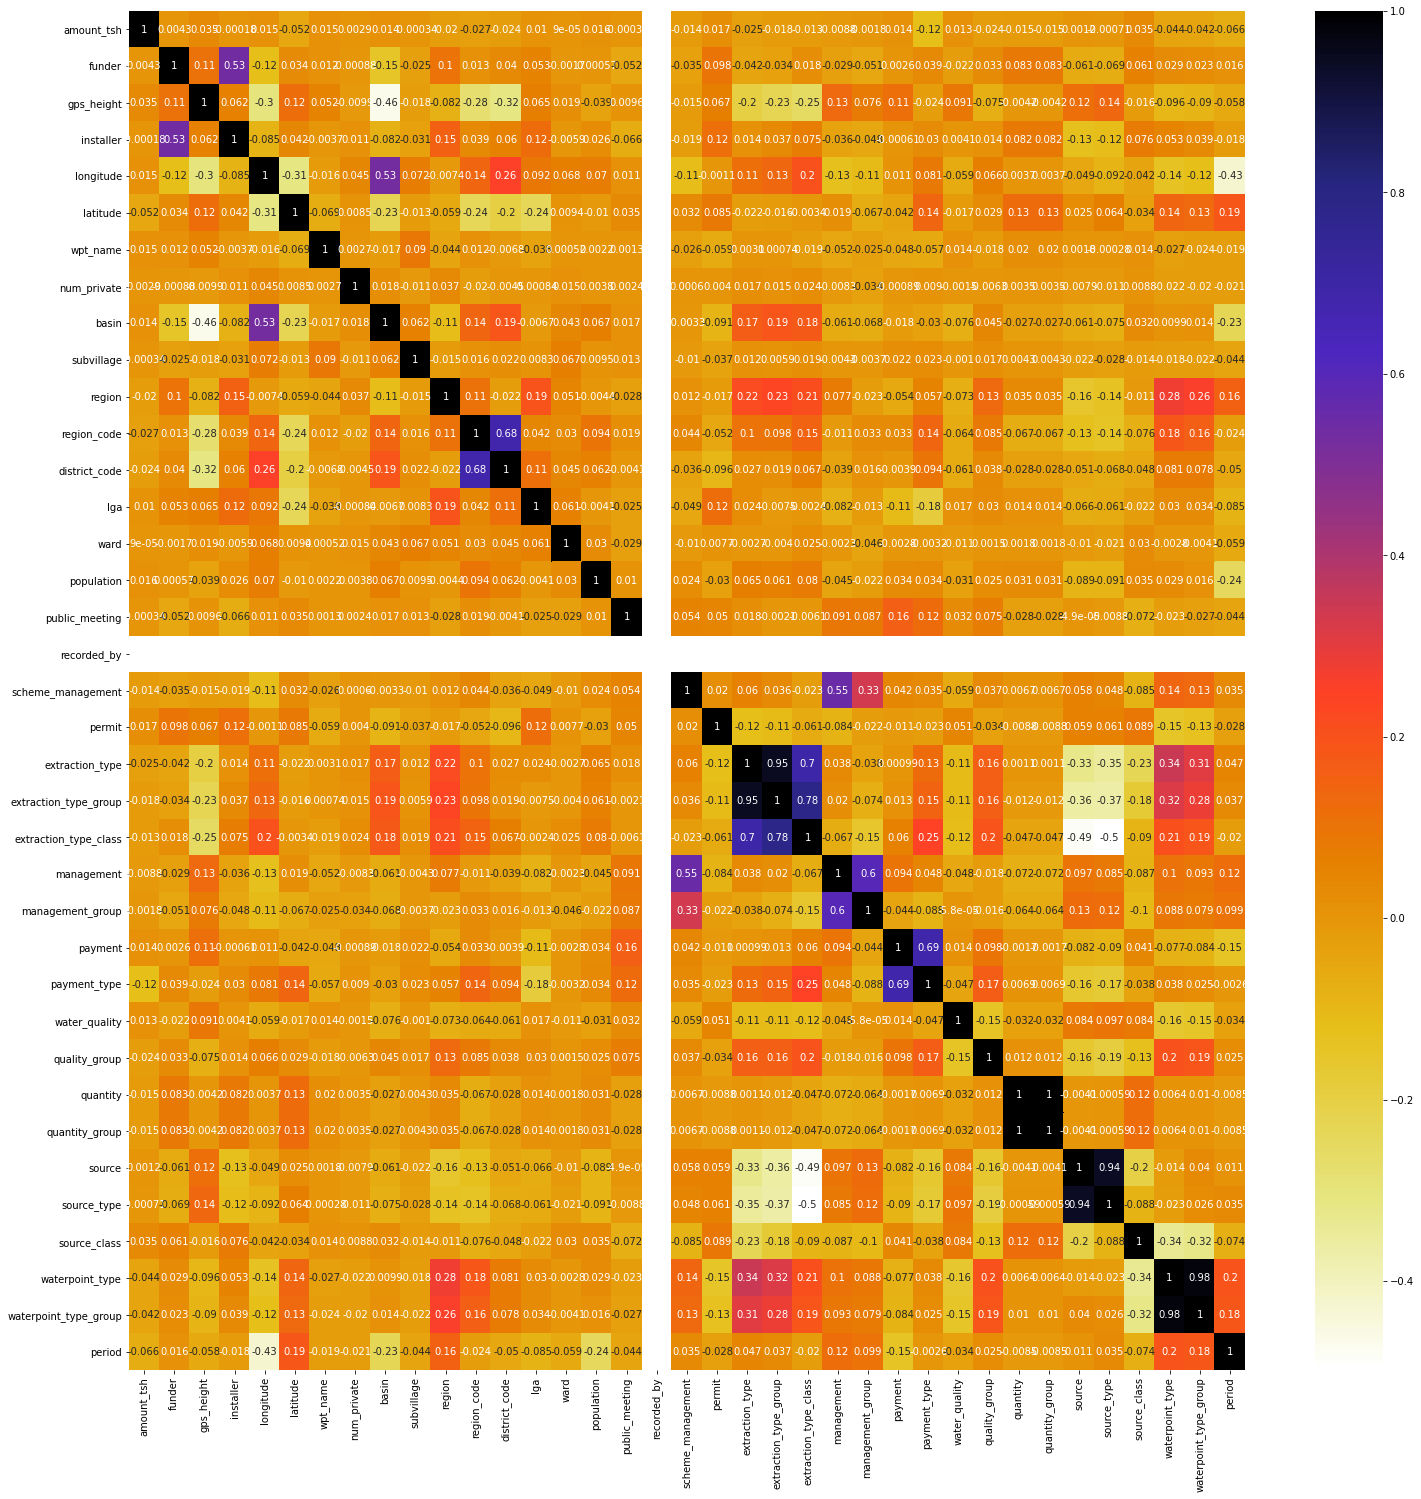

In [1478]:
# using Pearson Correlation
plt.figure(figsize=(25,25))
cor = train_set.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [1479]:
# function to display highly correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [1480]:
# get correlated features with threshhold 0.85
corr_features = correlation(train_set, 0.85)
len(set(corr_features))

4

In [1481]:
# display correlated features
corr_features

{'extraction_type_group',
 'quantity_group',
 'source_type',
 'waterpoint_type_group'}

In [1482]:
# drop correlated features
train_set.drop(corr_features, axis=1, inplace = True)
test_set.drop(corr_features, axis=1, inplace = True)

### **Drop columns**

In [1483]:
# # Combine train_set and test_set
# all_data = pd.concat([train_set, test_set], axis=0, sort=False)

In [1484]:
train_set.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'permit',
       'extraction_type', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'source', 'source_class',
       'waterpoint_type', 'period'],
      dtype='object')

In [1485]:
# drop unwanted columns from train and test data
# to_drop = ['date_recorded', 'recorded_by', 'quantity_group', 'water_quality', 'payment_type', 'num_private']
# to_drop = ['date_recorded', 'recorded_by', 'water_quality', 'payment_type', 'num_private', 'construction_year']
to_drop = ['recorded_by', 'date_recorded', 'water_quality', 'payment_type', 'num_private']

train_set.drop(to_drop, axis=1, inplace=True)
test_set.drop(to_drop, axis=1, inplace=True)

### **Split train data for evaluation**

In [1486]:
train_set['status_group'] = y

In [1487]:
X_train = train_set.drop('status_group',axis=1)
y_train = train_set['status_group']

In [1488]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

### **Handle unbalanced train data**

In [1489]:
# using SMOTE for unbalanced train dataset
counter = Counter(y_train)
print ("Before", counter)
smt = SMOTE()
X_train_os, y_train = smt.fit_sample(X_train, y_train)
counter = Counter(y_train)
print ("After", counter)

Before Counter({'functional': 25775, 'non functional': 18278, 'functional needs repair': 3467})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After Counter({'non functional': 25775, 'functional': 25775, 'functional needs repair': 25775})


In [1490]:
# # using ADASYN for unbalanced train dataset
# counter = Counter(y_train)
# print ("Before", counter)
# ada = ADASYN()
# X_train_os, y_train = ada.fit_sample(X_train, y_train)
# counter = Counter(y_train)
# print ("After", counter)

In [1491]:
# # using SMOTE+Tomek for unbalanced train dataset
# counter = Counter(y_train)
# print ("Before", counter)
# smtmk = SMOTETomek()
# X_train_os, y_train = smtmk.fit_sample(X_train, y_train)
# counter = Counter(y_train)
# print ("After", counter)

In [1492]:
# # using SMOTE+ENN for unbalanced train dataset
# counter = Counter(y_train)
# print ("Before", counter)
# smtenn = SMOTEENN()
# X_train_os, y_train = smtenn.fit_sample(X_train, y_train)
# counter = Counter(y_train)
# print ("After", counter)

In [1493]:
# # scatter plot of examples by class label
# plt.subplots(figsize=(8,5))
# for label, _ in counter.items():
#   row_ix = where(y_train == label)[0]
#   pyplot.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=str(label))
# plt.legend()
# plt.show()

In [1494]:
# Retain train columns after oversampling
X_train = pd.DataFrame(X_train_os, columns=X_train.columns)

In [1495]:
# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

# **Model Training**

In [1496]:
# Decision Tree Classifier
modelDTC = DecisionTreeClassifier(
    criterion='gini', 
    max_depth=10,
    min_samples_leaf=1, 
    min_samples_split=2
    )

# fit the DTC model on the training dataset
modelDTC.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [1497]:
# Random Forest Classifier 
modelRFC = RandomForestClassifier(bootstrap=True,
                                  criterion='gini',
                                  min_impurity_decrease=0.0,
                                  min_samples_leaf=1,
                                  min_samples_split=2,
                                  n_estimators=1000,
                                  n_jobs=1,
                                  oob_score=True,
                                  random_state=0
                              )

# fit the RFC model on the training dataset
modelRFC.fit(X_train, y_train)

print("OOB Score: %.4f" % modelRFC.oob_score_)

OOB Score: 0.8607


In [1498]:
# # creating XGBoost classifier model object
# modelXGB = XGBClassifier(learning_rate=0.01,
#                          n_estimators=200,
#                          max_depth=3,
#                          min_child_weight=5,
#                          reg_alpha=0.005,
#                          # subsample=1,
#                          # objective='binary:logistic',
#                          nthread=2,
#                          colsample_bytree=0.8,
#                          )

# # fit the XGBoost model on the training dataset
# modelXGB.fit(X_train, y_train)

In [1499]:
# # Cat Boost Classifier
# modelCBC = CatBoostClassifier(iterations=2000,
#                               random_state=1,
#                               reg_lambda=30,
#                               max_depth=3,
#                               max_ctr_complexity=5,
#                               eval_metric='AUC',
#                               task_type='CPU',
#                               od_type='Iter',
#                               od_wait=500
#                               )

# # fit the CBC model on the training dataset
# # categorical = np.where(X_train.dtypes == object)[0];categorical
# # modelCBC.fit(X_train, y_train, verbose=1000, eval_set=[(X_train,y_train),(X_test,y_test)], use_best_model=True, cat_features=categorical)
# modelCBC.fit(X_train, y_train, verbose=1000)

In [1500]:
# Function to display order of important features in a chart
def displayImportantFeatures(model, modelName):
    importances = pd.DataFrame(model.feature_importances_, index = X_train.columns)
    importances.sort_values(by = 0, inplace=True, ascending = False)
    importances = importances
    plt.figure(figsize=(10, 15)) 
    sns.barplot(x=0, y=importances.index, data=importances,palette="deep").set_title("Feature Importances for "+ modelName);
    sns.despine()

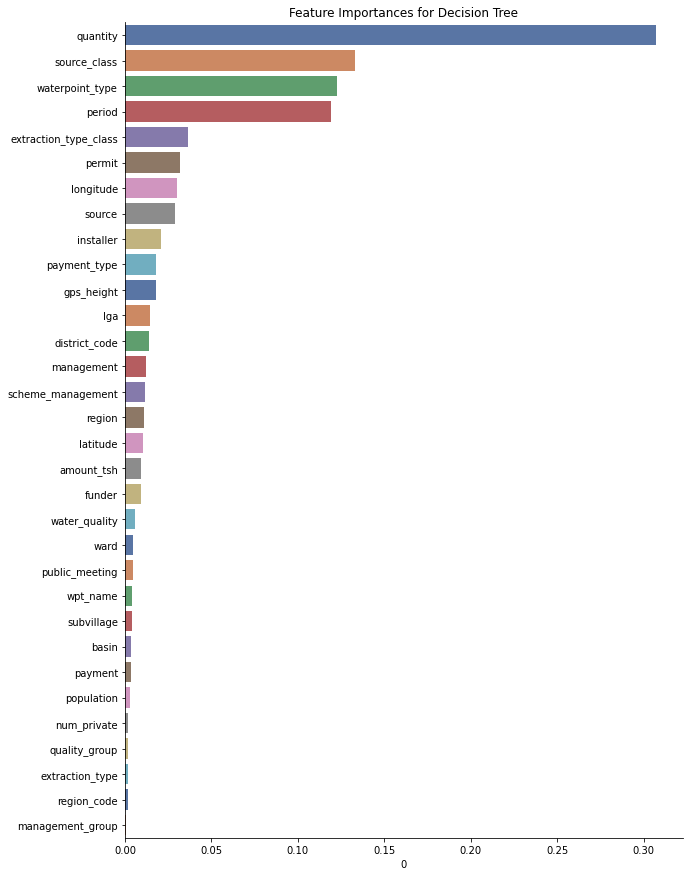

In [1501]:
try:
  displayImportantFeatures(modelDTC, "Decision Tree")
except NameError:
    print("Model is not defined!")

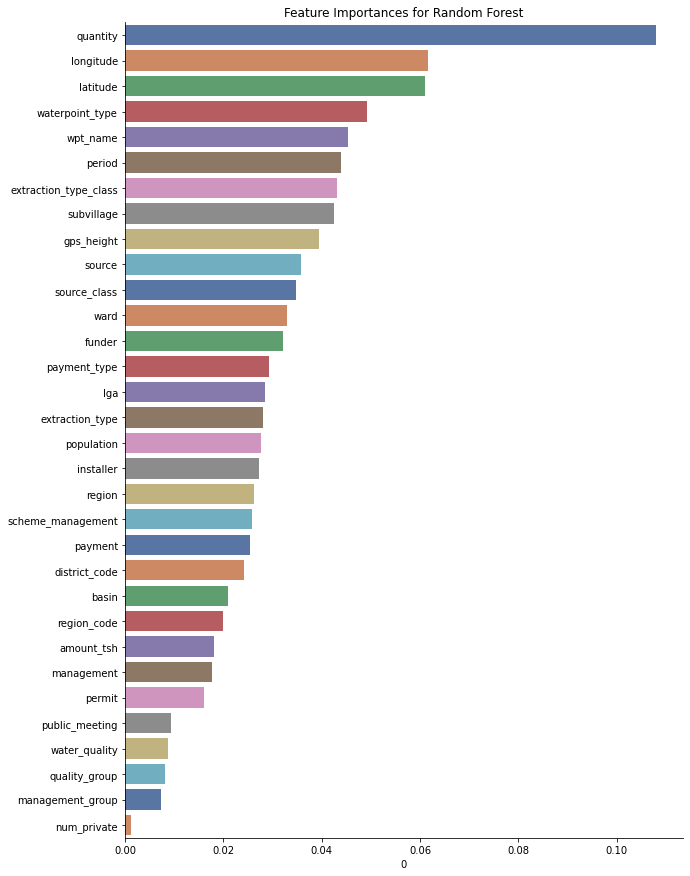

In [1502]:
try:
  displayImportantFeatures(modelRFC, "Random Forest")
except NameError:
    print("Model is not defined!")

In [1503]:
try:
  displayImportantFeatures(modelXGB, "XGBoost")
except NameError:
    print("Model is not defined!")

ValueError: ignored

In [ ]:
# try:
#   displayImportantFeatures(modelCBC, "Cat Boost")
# except NameError:
#     print("Model is not defined!")

# **Model Predictions**

### **Predictions for split test data**

In [1504]:
def calcScore(model, modelName):
  try:
    print ("Score calculated for " + modelName + "\n")

    # make probability predictions with the model for held out test data
    y_test_pred = model.predict(X_test)

    # Confusion matrix for held out test data
    confusionmatrix = confusion_matrix(y_test, y_test_pred)
    # print(confusionmatrix)
    plt.figure(figsize=(4,3))
    sns.heatmap(confusionmatrix, annot=True, cmap="Greys", fmt="d", 
                xticklabels = ['functional', 'non functional', 'functional needs repair'], 
                yticklabels = ['functional', 'non functional', 'functional needs repair'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix - " + modelName);
    
    # Classification report for held out test data
    print(classification_report(y_test, y_test_pred))
  except NameError:
    print("Data set was not splitted!")

Score calculated for Decision Tree

                         precision    recall  f1-score   support

             functional       0.72      0.86      0.79      6484
functional needs repair       0.29      0.29      0.29       850
         non functional       0.83      0.59      0.69      4546

               accuracy                           0.72     11880
              macro avg       0.61      0.58      0.59     11880
           weighted avg       0.73      0.72      0.71     11880



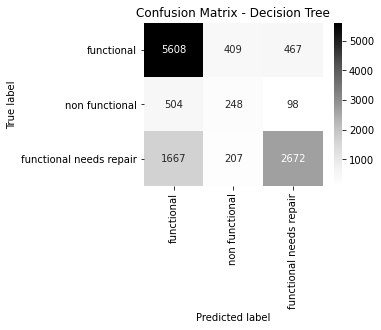

In [1505]:
try:
  calcScore(modelDTC, "Decision Tree")
except NameError:
    print("Model is not defined!")

Score calculated for Random Forest

                         precision    recall  f1-score   support

             functional       0.82      0.87      0.84      6484
functional needs repair       0.51      0.39      0.44       850
         non functional       0.83      0.79      0.81      4546

               accuracy                           0.81     11880
              macro avg       0.72      0.68      0.70     11880
           weighted avg       0.80      0.81      0.80     11880



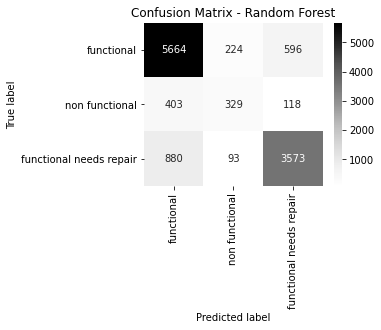

In [1506]:
try:
  calcScore(modelRFC, "Random Forest")
except NameError:
    print("Model is not defined!")

In [1507]:
try:
  calcScore(modelXGB, "XGBoost")
except NameError:
    print("Model is not defined!")

Score calculated for XGBoost



ValueError: ignored

In [ ]:
# try:
#   calcScore(modelCBC, "Cat Boost")
# except NameError:
#     print("Model is not defined!")

### **Predictions for submission test data**

In [1508]:
model = modelRFC

In [1509]:
# Make predictions for test data
X_pred = test_set
y_pred = model.predict(X_pred)

In [1510]:
# assign predicted values to submission
submission['status_group'] = y_pred

# create csv from submission
submission.to_csv('submission.csv', index=False)

In [1512]:
# download submission file
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>